In [1]:
from aicspylibczi import CziFile
import czifile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
import os
import imageio
import ffmpeg
import time
import pandas as pd
from cellpose import io, models

In [2]:
fname = "/home/ssa2206/dicty_factin_pip3-06_processed.czi"
video = CziFile(fname)
video.get_dims_shape()[0]
#X and Y are coords
#Z is the Z Slice
#C is channels
#T is time
#S is the "scenes"/angles but there's only one 

{'X': (0, 475),
 'Y': (0, 2048),
 'Z': (0, 114),
 'C': (0, 2),
 'T': (0, 241),
 'S': (0, 1)}

In [15]:
z50, shp = video.read_image(S=0, Z=50, C=0, T=50) 
shp

[('S', 1), ('T', 1), ('C', 1), ('Z', 1), ('Y', 2048), ('X', 475)]

In [16]:
def get_image(timestep=-1, z_plane=50, czi=video, channel=0):
    dims = video.get_dims_shape()[0]
    
    timestep = timestep % dims['T'][-1]
    z_plane = z_plane % dims['Z'][-1]
    img, shp = video.read_image(S=0, Z=z_plane, T=timestep, C=channel)
    #print(shp)
    return(img.squeeze()) # returns (channels, Y, X)

In [24]:
test_img = get_image(50, 100, video, channel=0)

In [25]:
masks, flows, styles = models.CellposeModel(model_type='cyto3').eval(test_img,
                            diameter=None, channels=[0,0])

In [43]:
masks.shape
np.max(masks)

8

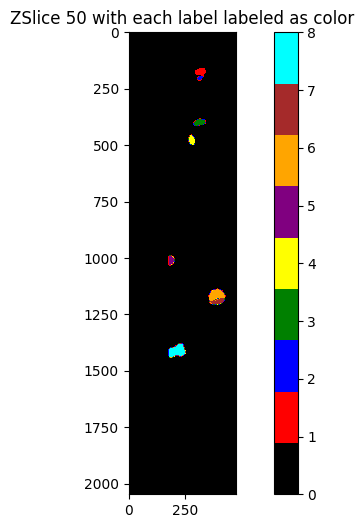

In [41]:
import matplotlib.colors as mcolors
#8 colors for this piece
colors = ['black', 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'cyan']
cmap = mcolors.ListedColormap(colors)

# Displaying the image with the custom colormap
plt.figure(figsize=(10, 6))
plt.imshow(masks, cmap=cmap)
plt.colorbar()  # Add a colorbar to show the mapping of values to colors
plt.title('ZSlice 50 with each label labeled as color')
plt.show()

In [ ]:
masks = np.load("pip3-06_processed_frame_masks_z50.npy")
#this is all the timesteps of 50

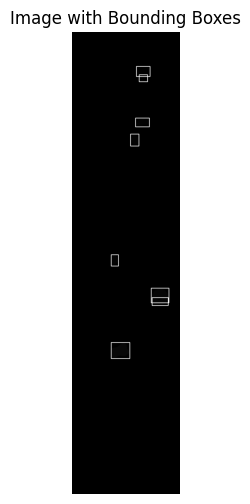

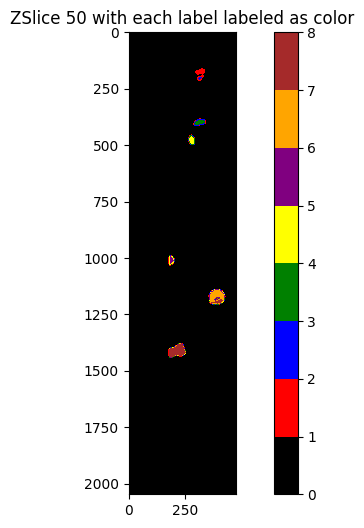

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_bounding_box(mask, cellID, padding=3):
    binary_array = (mask == cellID)
    # Convert binary array to binary image
    binary_image = np.uint8(binary_array * 255)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if(len(contours) == 0):
        print("Contour not found")
        return(-1)
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(contours[0])
    
    # Apply padding
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding    
    return(x, y, w, h)

#masks = np.uint8(masks)

# Get unique colors in the image
unique_colors = np.unique(masks)

# Create a copy of the image for visualization
image_with_boxes = np.copy(masks)

# Draw bounding boxes for each unique color
for color in unique_colors:
    if color == 0:  # Skip background
        continue
    x, y, w, h = get_bounding_box(masks, color)
    if x != -1:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    
    

# Display the image with bounding boxes
plt.figure(figsize=(10, 6))
plt.imshow(image_with_boxes, cmap='gray')
plt.axis('off')
plt.title('Image with Bounding Boxes')

#display the color maps
plt.figure(figsize=(10, 6))
plt.imshow(masks, cmap=cmap)
plt.colorbar()  # Add a colorbar to show the mapping of values to colors
plt.title('ZSlice 50 with each label labeled as color')
plt.show()

In [ ]:
class CziVideo:
    def __init__(self, fpath):
        self.file = fpath
        self.video = CziFile(fpath)
        self.dims = self.video.get_dims_shape()[0]

        self.num_frames = self.dims['T'][-1]
        self.num_zslices = self.dims['Z'][-1]
        print(f"Video with {self.num_frames} frames, {self.num_zslices} z slices")

        self.num_cells_per_frame = {}
        self.cell_masks = {}

    def get_plane(self, z_plane, scale=True):
        plane, shp = self.video.read_image(S=0, Z=z_plane, C=self.channel)
        if(scale):
            plane = self.scale_img(plane)

        return(plane.squeeze())
    
    def get_image(self, z_plane, timestep, channel=0, scale=True):
        timestep = timestep % self.num_frames
        z_plane = z_plane % self.num_zslices
        img, shp = self.video.read_image(S=0, Z=z_plane, T=timestep, C=channel)
        img = img.squeeze()
        if(scale):
            img = self.scale_img(img)
        return(img) # returns (channels, Y, X)

    def scale_img(self, img):
        lower_bound = np.percentile(img, 1)
        upper_bound = np.percentile(img, 99.9)
        I = (img - lower_bound) / (upper_bound - lower_bound)
        I = np.clip(I, 0, 1)
        return(I)

    def load_segmentation_masks(self, zplane=50, verbose=False):
        print(f"Loading segmentation masks for zplane {zplane}")
        num_cells = []
        cell_masks = []
        flows = []
        styles = []
        for frame in range(self.dims['T'][-1]):
            if(verbose):
                print(f"Computing for timestep {frame}")
            img = self.get_image(zplane, frame)
            mask, flow, style = models.CellposeModel(model_type='cyto3').eval(img,
                                    diameter=None, channels=[0,0])
            cell_masks.append(mask)
            flows.append(flow)
            styles.append(style)
            N = len(np.unique(masks))
            num_cells.append(N)

        self.num_cells_per_frame[zplane] = num_cells
        self.cell_masks[zplane] = {
            "masks" : np.array(cell_masks),
            "flows" : flows,
            "styles" : styles,
        }

    def calculate_bounding_boxes(self, zplane=50, verbose=False, padding=10):
        print(self.cell_masks.keys(), zplane in self.cell_masks.keys())
        masks = self.cell_masks[zplane]['masks']
        bounding_boxes = {}
        for frame, num_cells_in_frame in enumerate(self.num_cells_per_frame[50]):
            mask = masks[frame]
            bounding_boxes[frame] = []
            for cell_id in range(num_cells_in_frame):
                if verbose:
                    print(f'Fetching cell {cell_id} from frame {frame}')
                binary = np.uint8((mask==cell_id) * 255)
                contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if(len(contours) == 0):
                    if(verbose):
                        print("contour not found")
                    
                else:
                    x, y, w, h = cv2.boundingRect(contours[0])
                    x -= padding
                    y -= padding
                    w += 2 * padding
                    h += 2 * padding
                    bounding_boxes[frame].append((x, y, w, h))
        self.cell_masks[zplane]['boxes'] = bounding_boxes
        return(bounding_boxes)
            


    def find_bounding_box(self, mask, cellID, padding=3):
        binary_array = (mask == cellID)
        # Convert binary array to binary image
        binary_image = np.uint8(binary_array * 255)
        
        # Find contours
        
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(f"Contours size {len(contours)}")
        # Get the bounding rectangle
        x, y, w, h = cv2.boundingRect(contours[0])
        
        # Apply padding
        x -= padding
        y -= padding
        w += 2 * padding
        h += 2 * padding
        return(x, y, w, h)

    def draw_bounding_box(self, image, rec, value, thickness=3):
        # value is what pixel val want to put there
        x, y, w, h = rec
        # Draw bounding box over image
        bounding_box_image = cv2.rectangle(image, (x, y), (x + w, y + h), value, thickness)
        
        return bounding_box_image, (x, y, w, h)


    def get_cell_mask(self, zplane, frame, cell_num):
        if(len(self.cell_masks) > 0 and zplane in self.cell_masks.keys()):
            masks = self.cell_masks[zplane]["masks"]
            if(cell_num < self.num_cells_per_frame[zplane][frame]):
                print(f"Fetching mask for cell {cell_num} out of {self.num_cells_per_frame[zplane][frame]} cells in frame")
                return(masks[frame] == cell_num)
            else:
                print(f"Requested cell id {cell_num} out of range. This frame has only {self.num_cells_per_frame[zplane][frame]} cells")
                return(-1)
        else:
            print("This zplane has not loaded masks yet. Try running load_segmentation_masks(zplane) first!")
            return(-1)


[('S', 1), ('T', 241), ('C', 1), ('Z', 1), ('Y', 2048), ('X', 475)]